# Information
$Writer:{\;}Junhyuck{\;}Woo
\\ Std. ID: 20145337
\\Project:{\;}Apply{\;}K-means{\;}algorithm{\;}to{\;}both{\;}image{\;}value{\;}and{\;}its{\;}spatial{\;}domain$

# import library

In [1]:
from collections import Counter
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
import random as rd
from PIL import Image

# Load file

In [2]:
image = Image.open('Lenna.png').convert('RGB')
data = np.array(image)

# Function: Generate Matrix

In [3]:
def generate_spatial_data(row, col):
    spatial_data = np.zeros((row, col, 2), dtype='f')
    for i in range(row):
        for j in range(col):
            spatial_data[i][j][0] = j
            spatial_data[i][j][1] = i
    spatial_data[:,:,0] = normalize(spatial_data[:,:,0])
    spatial_data[:,:,1] = normalize(spatial_data[:,:,1])
    return(spatial_data)

# Function: Normalize the values of the input data to be [0, 1]

In [4]:
def normalize(data):
    data_normalized = (data - np.min(data)) / (np.max(data) - np.min(data))
    return(data_normalized)

# Function: L2-norm

In [5]:
def l2_norm(x, y):
    d = (x - y) * (x - y)
    s = np.sum(d)
    r = np.sqrt(s)
    return(s)

# Function: L1-norm

In [6]:
def l1_norm(x,y):
    d = np.absolute(x-y)
    s = np.sum(d)
    return(s)

# Function: Centroid Combination

In [7]:
def centroid_combination(row, col, n_c, centroid, centroid_label):
    result = np.zeros((row, col, n_c), dtype=float)
    for i in range(row):
        for j in range(col):
            result[i,j,:] = centroid[:, centroid_label[i,j]]
    return(normalize(result))

# Function: Visualizer

In [8]:
def visualizer(data, data_label):
    f1 = plt.figure(1)

    plt.title(data_label)
    plt.imshow(data, interpolation='None')

    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
        
    plt.show()

# Function: Whitening

In [9]:
def whitening(row, col, data):
    m = cal_mean(row, col, data)
    std = cal_std(row, col, data, m)
    w = (data-m)/std
    return(m, std, w)

# Function: Dewhitening

In [10]:
def dewhitening(m, std, data, option):
    if option == 'o':
        o = (data*std) + m
    elif option =='c':
        o = data.T*std + m
        o = o.T
    return(o)

# Function: Calculate Mean

In [11]:
def cal_mean(row, col, data):
    m = 0;
    for i in range(row):
        for j in range(col):
            m += data[i][j]
    return(m / (row*col))

# Function: Calculate Standard

In [12]:
def cal_std(row, col, data, mean):
    std = cal_mean(row, col, data*data) - (mean* mean)
    return(np.sqrt(std))

# Function: Initialize Centroid Label

In [13]:
def initialize_centroid_label(row, col, k):
    num_data = row*col
    centroid_label = np.empty(num_data, dtype=int)
    
    # clustering
    for i in range(num_data):
        label = rd.randint(1, k) - 1
        centroid_label[i] = label
    
    return(centroid_label.reshape((row, col)))

# Function: Calculate Centroid (Average)

In [14]:
def calculate_average_centroid(row, col, k, data, centroid_label):
    num_data = row * col
    centroid = np.zeros((data.shape[2], k), dtype=float)
    count = np.zeros(k,dtype=int)
    
    # Create centroid image
    for i in range(row):
        for j in range(col):
            index = centroid_label[i,j]
            centroid[:,index] += data[i,j,:]
            count[index] += 1
    
    for i in range(k):
        if (count[i] != 0):
            centroid[:, i] /= count[i]

    return(centroid)

# Function: Calculate Centroid (Median)

In [15]:
def calculate_median_centroid(row, col, k, data, centroid_label):
    x_buf = np.zeros((k, row*col), dtype=float)
    y_buf = np.zeros((k, row*col), dtype=float)
    centroid = np.zeros((2, k), dtype=float)
    count = np.zeros(k, dtype=int)
    
    for i in range(row):
        for j in range(col):
            index = centroid_label[i,j]
            x_buf[index, count[index]]= data[i,j,0]
            y_buf[index, count[index]]= data[i,j,1]
            count[index]+=1
            
    for i in range(k):
        if count[i]==0:
            centroid[:,i] = np.array([0, 0])
            continue
    
        x_centroid = x_buf[i, 0:count[i]]
        y_centroid = y_buf[i, 0:count[i]]
        

        x_centroid = np.sort(x_centroid)
        y_centroid = np.sort(y_centroid)
        x = x_centroid[int(count[i]/2)]
        y = y_centroid[int(count[i]/2)]
        centroid[:,i] = np.array([x, y])
        
    return(centroid)

# Function: Clustering Data

In [16]:
def clustering(row, col, n_k, lamda, data, centroid, spatial_data, spatial_centroid):
    num_data = row * col
    cluster_label = np.empty((row, col),dtype=int)
    dist = np.empty(n_k, dtype=float)
    
    for i in range(row):
        for j in range(col):
            for k in range(n_k):
                dist[k] = l2_norm(data[i,j,:], centroid[:,k]) + lamda*l2_norm(spatial_data[i,j,:], spatial_centroid[:,k])
            cluster_label[i,j] = np.argmin(dist)

    return(cluster_label)

# Function: Energy
$\sum_k \sum_\{ x \in I(k) \} [ \| f(x) - m_k \|^2 + a * \| x - c_k \|^2 ]$

In [17]:
def calculate_energy(row, col, lamda, data, px_centroid, px_centroid_label, spatial_data, spatial_centroid, spatial_centroid_label, option):
    energy = 0
    for i in range(row):
        for j in range(col):
            if option==0:
                energy += (l2_norm(data[i,j,:], px_centroid[:,px_centroid_label[i,j]]) + lamda*l2_norm(spatial_data[i,j,:], spatial_centroid[:, spatial_centroid_label[i,j]]))
            elif option ==1:
                energy += (l2_norm(data[i,j,:], px_centroid[:,px_centroid_label[i,j]])) 
            elif option ==2:
                energy += lamda*(l2_norm(spatial_data[i,j,:], spatial_centroid[:,spatial_centroid_label[i,j]])) 
    return(energy/(row*col))

# Function: K Means Algorithms

In [18]:
def k_means(k, lamda, data):
    data = normalize(data)
    row = data.shape[0]
    col = data.shape[1]
    spatial_data = generate_spatial_data(row, col)
    m, std, whiten_data = whitening(row, col, data)
    
    buf1 = 0
    buf2= 0
    energy = []
    energy1 = []
    energy2 = []
    train_accuracy = []
    test_accuracy = []
    real_label = np.empty(k, dtype=int)
    
    previous_label = np.zeros((row, col), dtype=int)
    centroid_label = initialize_centroid_label(row, col, k)
    
    while (~np.all(previous_label == centroid_label)):
        px_centroid = calculate_average_centroid(row, col, k, whiten_data, centroid_label)
        spatial_centroid = calculate_average_centroid(row, col, k, spatial_data, centroid_label)
        
        # check training energy
        buf1 = calculate_energy(row, col, lamda, whiten_data, px_centroid, centroid_label, spatial_data, spatial_centroid, centroid_label, 1)
        buf2 = calculate_energy(row, col, lamda, whiten_data, px_centroid, centroid_label, spatial_data, spatial_centroid, centroid_label, 2)
        energy1.append(buf1)
        energy2.append(buf2)
        energy.append(buf1+buf2)

        previous_label = centroid_label
        centroid_label = clustering(row, col, k, lamda, whiten_data, px_centroid, spatial_data, spatial_centroid)
        
    # Dewhitening
    original_centroid = dewhitening(m, std, px_centroid, "c")
    
    # Visualize K centroid images for each category.
    visualizer(centroid_combination(row, col, data.shape[2], original_centroid, centroid_label), 'clustering')

    # Plot the training energy per optimization iteration.
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.plot(energy1, label='Intensity Energy')
    plt.plot(energy2, label='Spatial Energy')
    plt.legend(loc='upper right')
    
    plt.subplot(122)
    plt.plot(energy, label='Energy')
    plt.legend(loc='upper right')
    plt.show()

# K = 2, a = 0

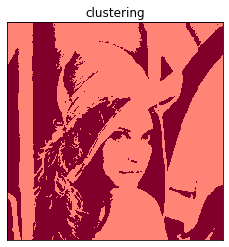

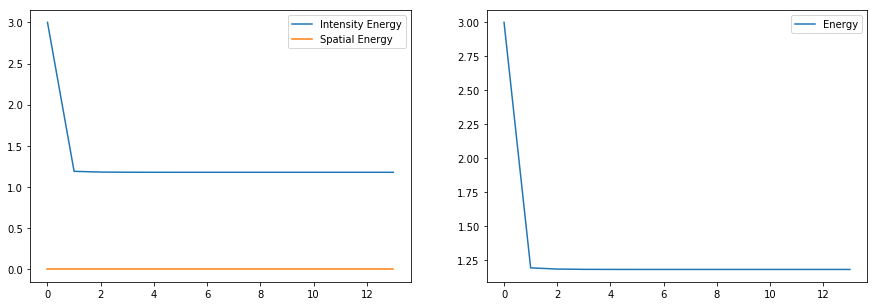

In [19]:
k_means(2, 0, data)

# K = 2, a = 20

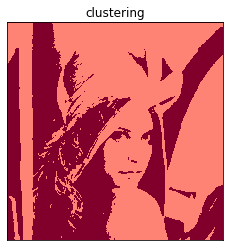

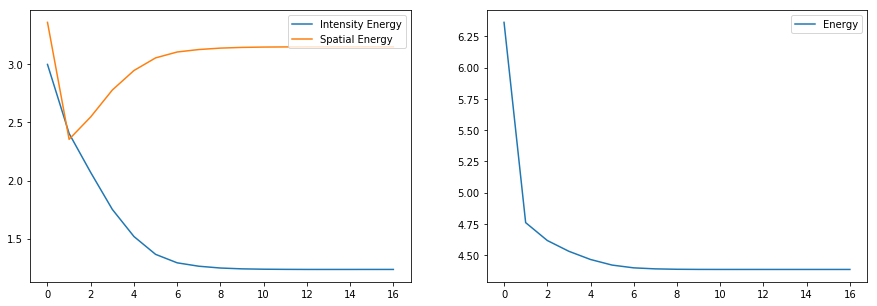

In [20]:
k_means(2, 20, data)

# k = 2, a = 100

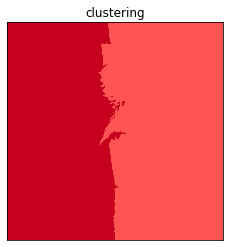

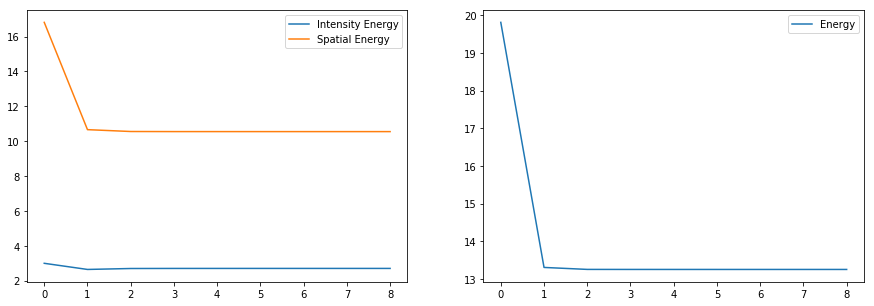

In [21]:
k_means(2, 100, data)

# k = 4, a = 20

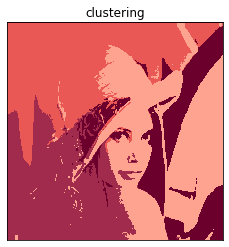

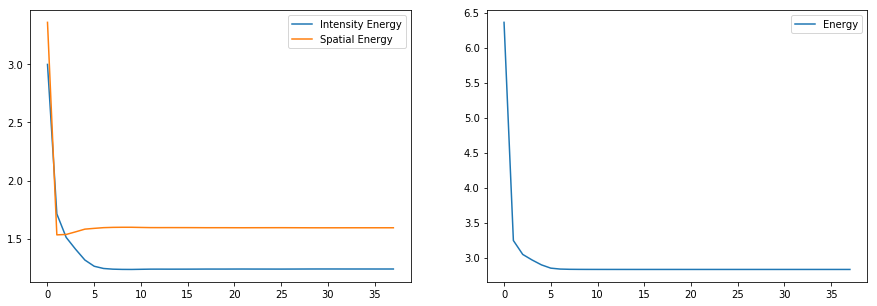

In [22]:
k_means(4, 20, data)

# K = 8, a = 20

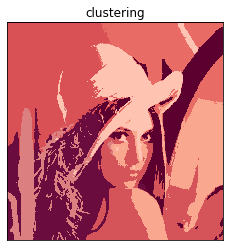

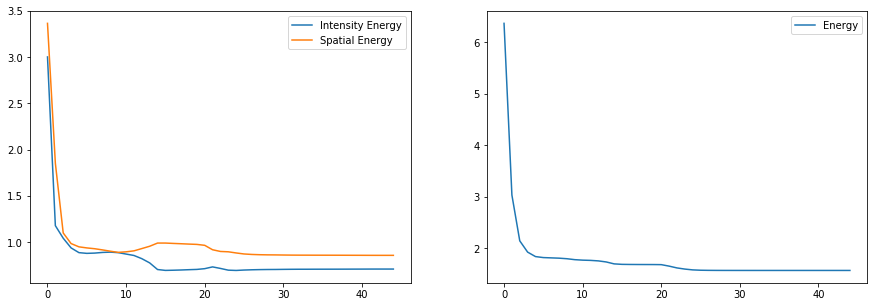

In [23]:
k_means(8, 20, data)

# K = 16, a = 20

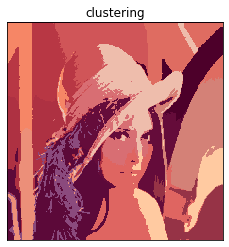

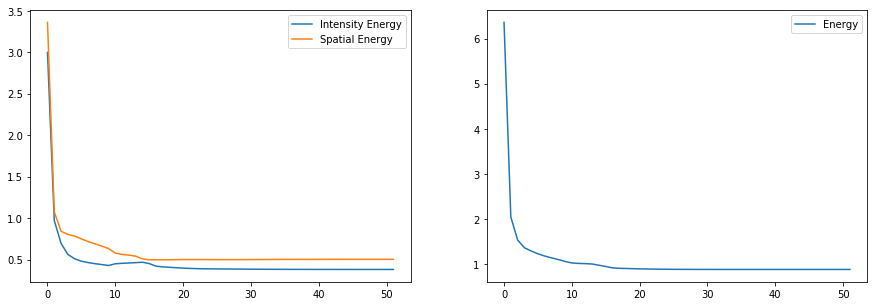

In [25]:
k_means(16, 20, data)